# KEY OBJECTS
----------------------

### database:
    Table (list of lists) containing: documentID, multiclass-label, 
    binclass-label, document-text string as well as an intermediately 
    generated column: words from document-text as list.

### words:
    Counter object containing: dictionary-word and count (count across 
    the entire corpus). The words are filtered by frequency and/or 
    parts-of-speech. This object represents likely significant words.

### id2words:
    Dictionary object containing ID and word.

### corpus_i2w:
    (list of lists) list of abstract in id2word notation, where words
    in a document are replaced with indices from the id2words id2words 
    map

### corpus_bow:
    (listfo lists) list of abstracts in BoW notation, where a vector of
    ordered dictionary words has document word-counts as elements.

### Table showing production and use of data objects:
    U = Uses, P = Produces, - = Not Applicable

|  | database[:,0:3] | database[:,4] | words | id2words | corpus_i2w | corpus_bow | model_w2v | model_lsi | model_xdx | model_spam |
|-------------------|:---------------:|:-------------:|:-----:|:--------:|:----------:|:----------:|:---------:|:---------:|:---------:|:----------:|
| Load()            |        P        |       -       |   -   |     -    |      -     |      -     |     -     |     -     |     -     |      -     |
| Sanitize()        |        U        |       P       |   P   |     -    |      -     |      -     |     -     |     -     |     -     |      -     |
| Featurize()       |        -        |       U       |   -   |     P    |      P     |      P     |     -     |     -     |     -     |      -     |
| KeywordAnalysis() |                 |               |       |          |            |            |           |           |           |            |
| Word2Vec_Train()  |        -        |       U       |   -   |     -    |      -     |      -     |     P     |     -     |     -     |      -     |
| Word2Vec_Apply()  |        -        |       -       |   -   |     -    |      -     |      -     |     U     |     -     |     -     |      -     |
| LSI_Train()       |        -        |       U       |   -   |     U    |      U     |      -     |     -     |     P     |     -     |      -     |
| LSI_Apply()       |        U        |       -       |   -   |     U    |      U     |      -     |     -     |     U     |     -     |      -     |
| xDx_Train()       |        -        |       U       |   -   |     U    |      U     |      -     |     -     |     -     |     P     |      -     |
| xDx_Apply()       |        -        |       -       |   -   |     U    |      U     |      -     |     -     |     -     |     U     |      -     |
| Spam_Train()      |        U        |       -       |   -   |     -    |      -     |      U     |     -     |     -     |     -     |      P     |
| Spam_Apply()      |        U        |       -       |   -   |     -    |      -     |      U     |     -     |     -     |     -     |      U     |
|                   |                 |               |       |          |            |            |           |           |           |            |

https://www.tablesgenerator.com/markdown_tables

In [1]:
print("BEGIN application")

# REQUIREMENTS:
# pip install jupyterlab
# pip install gensim
# pip install nltk
# pip install sklearn
# pip install matplotlib
# pip install seaborn
# pip install pyLDAvis

BEGIN application


In [2]:
import os.path
import pickle                                # load saved models
import csv                                   # load,save files
import gensim.corpora as corpora             # to load cached id2words
from collections import Counter              # to load words Counter-dictionary
from gensim.models import LsiModel, LdaModel, HdpModel # to load saved models
from IPython.core.display import SVG         # to display flowcharts


In [42]:
#---------------------
#     DEBUGGING
#---------------------
USERARG_VERBOSE             = 1               # 2DEBUG. 0 off, 1 on. Prints more messages
USERARG_RECORD_LIMITER      = 0               # 2DEBUG. 0 means no limit, >= 1 limits database records

#---------------------
#  PREPROCESSING
#---------------------
USERARG_FILTER_WORDS        = 3000            # filter lower-frequency words (keeps KEYWORDS). 
USERARG_FILTER_POS          = 1               # Bool {0,1}. filter on parts-of-speech (keeps N,V,Adj,KEYWORDS).

# define data sources in load-database.ipynb
USERARG_DATABASEFILE        = "data_training"   # = { data_training, data_scopus, data_topic_sim }     data_experiment_wf1+a|b
USERARG_NGRAM_N             = 20               # the number of iterations to look for oft-repeated phrases
USERARG_NGRAM_MINCOUNT      = 25              # minimum word frequency for n-gram consideration
USERARG_NGRAM_THRESHOLD     = 100             # higher threshold = fewer phrases
USERARG_IMPOSE_DICTIONARY   = "data/dictionary.words"  # path/filename.words XOR empty-string
USERARG_NLTKDATADIR         = "c:\\users\\nk\\appdata\\local\\programs\\python\\python38-32\\lib\\nltk_data"
#USERARG_NLTKDATADIR         = "/home/nk/nltk_data"

#---------------------
# KEYWORDS
#---------------------

# WORD2VEC
USERARG_QTY_FEATURES        = 300             #
USERARG_QTY_MINWORDS        = 3               #
USERARG_SIZE_CONTEXT        = 7               #
USERARG_DOWNSAMPLING        = 1e-3            # 1e-5
USERARG_RANDOMNOSEED        = 1               # to debug else x
USERARG_WINDOWSIZEPCT       = 5               #

#---------------------
# TOPICS
#---------------------
USERARG_TOPIC_MODEL         = 'HDP'           # { 'HDP', 'LDA' } (Latent Dirichlet Allocation, Hierarchical Dirichlet process)
USERARG_NUMTOPICS           = 5               # 5
USERARG_WORDS_PER_TOPIC     = 10              # filters word in topic REPORTs, not from the model (lib.default=10)
USERARG_ITERATIONS          = 100             # 

# LATENT DIRCHLET ALLOCATION
USERARG_LDA_ITERATIONS      = 100             # 100/DB[650] had poor topic definition
USERARG_LDA_CHUNKSIZE       = 250             #

#---------------------
# SPAM-FILTER
#---------------------
USERARG_TRAINvTEST_SPLIT    = 0.2               # 0.2 is the default. Using 1.0 might cause overfitting
USERARG_SPAM_CLASSIFIER     = 'ADABOOST'    # = {'NAIVEBAYES', 'ADABOOST'} NOTE: ADABOO only works on data_training !?!

#---------------------
# MANUALLY IDENTIFIED KEYWORDS
#---------------------
KEYWORDS=[]

if USERARG_DATABASEFILE=="data_experiment_wf1a":
    KEYWORDS=['energy','consumption','utilization','forecast','prediction','trend']    
else:
    KEYWORDS=[
         'architecture'
        ,'autonomous'
        ,'autonomy'       
        ,'autonomously'   
        ,'agent'
        ,'body'
        ,'cognitive_robot'
        ,'cognitive_control'
        ,'cognitive_model'
        ,'control'
        ,'controller'
        ,'computation'
        ,'compliant'
        ,'compliant_robot'
        ,'discovery'
        ,'dynamic'
        ,'embodiment'
        ,'extensible'
        ,'extensibility'
        ,'flexible_robot'
        ,'intelligence'
        ,'learning_robot'
        ,'modular_robot'
        ,'modularity'
        ,'model'
        ,'morphology'
        ,'morphological'
        ,'networked_robot'
        ,'reconfigurable'
        ,'reconfigurable_robot'
        ,'reconfigurable_robots'
        ,'reconfigurable_robotics'
        ,'robots'
        ,'robot'
        ,'robotics'
        ,'self_aware'
        ,'self_conscious'
        ,'self_reflective'
        ,'sensorimotor'
        ,'sensori_motor'
        ,'topology'
        ,'unified_control'
    ]

In [4]:
#---------------------
# GLOBAL DATABASE CONSTANTS 
#---------------------
FIELD_BzNDX_DOCID          = 0
FIELD_BzNDX_INT_CLASS      = 1
FIELD_BzNDX_BIN_CLASS      = 2
FIELD_BzNDX_ABSTRACT       = 3
FIELD_BzNDX_ABSTRACT_WORDS = 4
EMPTY_DOCUMENT_VALUE = "-NULL-"

#---------------------
# LOCAL PARAMETERS
#---------------------
_INIT=0

_INSTR_KEYWORDS          =1

_INSTR_WORD2VEC_TRAIN    =2
_INSTR_WORD2VEC_VISUALIZE=3

_INSTR_LSI_TRAIN         =4
_INSTR_LSI_APPLY         =5

_INSTR_xDx_TRAIN         =6
_INSTR_xDx_VISUALIZE     =7
_INSTR_xDx_APPLY         =8

_INSTR_SPAM_TRAIN        =9
_INSTR_SPAM_APPLY        =10

_INSTR_LOAD_DB           =11
_INSTR_LOAD_SANITIZE     =12
_INSTR_LOAD_CACHE        =13

_INSTR_SUPIMPOSE_DIC     =14
_INSTR_FEATURIZE         =15

_RUN_INTERATION          = 0

In [5]:

def root_filename(folder, extension):
    _TMP_FILE  = folder + '/' + USERARG_DATABASEFILE
    _TMP_FILE += '-recs=' + str(USERARG_RECORD_LIMITER)
    _TMP_FILE += '-wrds=' + str(USERARG_FILTER_WORDS)
    _TMP_FILE += '-posf=' + str(USERARG_FILTER_POS)
    _TMP_FILE += '-ngmn=' + str(USERARG_NGRAM_MINCOUNT)
    _TMP_FILE += '-ngtr=' + str(USERARG_NGRAM_THRESHOLD)
    _TMP_FILE += '.' + extension
    return _TMP_FILE



# if no specific filename is given, then use user args to build a filename
def load_words(filename = ""):
    print("Loading cached words...")
    global words
    if len(filename) == 0:
        filename = root_filename('data','words')
    assert(os.path.exists(filename))

    words = Counter()
    with open(filename) as fp:
        csv_reader = csv.reader(fp, delimiter=',', quotechar='"')
        for data in csv_reader:
            for record in data:
                _tuple = eval(record)
                words[_tuple[0]] = _tuple[1]

                

def load_database(filename = ""):
    print("Loading cached database...")
    global database
    if len(filename) == 0:
        filename = root_filename('data','sandb')
    assert(os.path.exists(filename))

    database = []
    with open(filename, encoding='utf-8') as fp:
        csv_reader = csv.reader(fp, delimiter=',', quotechar='"')
        for data in csv_reader:
            _fields = []
            for field in data:
                try:
                    _fields.append(eval(field))
                except:
                    _fields.append(field)
            database.append(_fields)

          
                
# save a copy of best as "data.id2words" or use params to gen filename
def load_id2words(filename = ""):
    print("Loading cached id2words...")
    global id2words
    if len(filename) == 0:
        filename = root_filename('data','id2words')
    assert(os.path.exists(filename))

    #id2words = corpora.Dictionary.load(filename)  # binary
    id2words = corpora.Dictionary.load_from_text(filename)
    print(id2words)
    assert(id2words)

    
def load_corpus_i2w(filename = ""):
    print("Loading cached corpus_i2w...")
    global corpus_i2w
    if len(filename) == 0:
        filename = root_filename('data','corpus.i2w')
    assert(os.path.exists(filename))
    corpus_i2w = corpora.MmCorpus(filename)
    print(corpus_i2w)
    assert(corpus_i2w)
    


def load_corpus_bow(filename = ""):
    print("Loading cached corpus_bow...")
    global corpus_bow
    if len(filename) == 0:
        filename = root_filename('data','corpus.bow')
    assert(os.path.exists(filename))
    #corpus_bow = corpora.MmCorpus(filename)
    corpus_bow = pickle.load( open(filename, "rb" ) )
    print(corpus_bow)
    assert(corpus_bow)
    

# load_words('data/words.dic') or load_words() no filename will build a filename from current settings

In [6]:
def filter_db_docwordlist_using_words(WORDS, MSG):
    print("\tFiltering abstract-word-list using words-list",MSG)
    iTime = time.time()

    _len1 = len(database[0][FIELD_BzNDX_ABSTRACT_WORDS])
    _count = 0

    for i in range(len(database)):
        tokens = [word for word in database[i][FIELD_BzNDX_ABSTRACT_WORDS] if word in WORDS]
        database[i][FIELD_BzNDX_ABSTRACT_WORDS] = tokens
        _count += len(tokens)

    _len2 = len(database[0][FIELD_BzNDX_ABSTRACT_WORDS])

    if _len2 < _len1:
        print("\t\tConfirmed reduction in document word-list")
    else:
        print("\t\tWARN: Unable to confirm reduction in document word-list")
    print("\t\t",_count,"words currently in corpus")
    
    print("\tCompleted in", round(time.time() - iTime,3),"seconds")
    return None

In [7]:
def process_router(PROCESSOR_SWITCH, USE_CACHE):
    global _INIT
    global database
    global words
    global model_spam
    global model_w2v
    global model_lsi
    global model_xdx
    global id2words
    global corpus_i2w
    global corpus_bow
    
    
    # ==============================================
    # -------------- INITIALIZATION --------------
    # ==============================================

    
    if (PROCESSOR_SWITCH==_INSTR_LOAD_DB):
        _INIT=-2
        if USE_CACHE==1:
            load_database()
            load_words()
        else:        
            %run ./modules/load-database.ipynb
            %run ./modules/sanitize.ipynb
        assert(len(database))
        assert(len(words))
        _INIT = -1


    elif (PROCESSOR_SWITCH==_INSTR_LOAD_CACHE):
        load_database()
        assert(len(database))
        load_words()
        assert(len(words))
        load_id2words()
        assert(len(id2words))
        load_corpus_i2w()
        assert(len(corpus_i2w))
        load_corpus_bow()
        assert(len(corpus_bow))
        _INIT = 1

        
    elif (_INIT!=0 and PROCESSOR_SWITCH==_INSTR_FEATURIZE):
        if USE_CACHE == 1:
            load_id2words()
            load_corpus_i2w()
            load_corpus_bow()
        else:
            %run ./modules/featurize.ipynb
        assert(len(id2words))
        assert(len(corpus_i2w))
        assert(len(corpus_bow))
        _INIT = 1


    elif (_INIT!=0 and PROCESSOR_SWITCH==_INSTR_SUPIMPOSE_DIC):
        load_words(USERARG_IMPOSE_DICTIONARY)
        filter_db_docwordlist_using_words(words,"...")
        print("\tINFO: Database size:",len(database), "x", len(database[0]))
        print("\tINFO: Be sure to run featurize() after superimposing().")
        _INIT = -1

        
    # ==============================================
    # -------------- KEYWORD ANALYSIS --------------
    # ==============================================
    
    
    # -------------- FREQUENCY ANALYSIS -------------
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_KEYWORDS):
        %run ./modules/keyword-analyzer.ipynb

    # ------------------- WORD2VEC -------------------
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_WORD2VEC_TRAIN):
        if USE_CACHE==0 or not os.path.exists('models/w2v.model'):
            %run ./modules/word2vec_train.ipynb
        else:
            model_w2v = pickle.load( open('models/w2v.model', "rb" ) )
        print(model_w2v)
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_WORD2VEC_VISUALIZE):
        %run ./modules/word2vec_visualize.ipynb
        
    # --------------- Latent Semantic Analysis (LSA) -------------
    # TO DO
        
        
        
    # ==============================================
    # ---------------- TOPIC ANALYSIS --------------
    # ==============================================
    
    
    # -------------- Latent Semantic Indexing (LSI) --------------
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_LSI_TRAIN):
        if USE_CACHE==0 or not os.path.exists('models/lsi.model'):
            %run ./modules/LSI_train.ipynb
        else:
            model_lsi = LsiModel.load('models/lsi.model')  # load models and projection
            load_id2words() # needs it's buddy id2words
        print(model_lsi)
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_LSI_APPLY):
        %run ./modules/LSI_apply.ipynb


    # ----------- Latent Dirschlet Allocation (LDA) --------------
    # --------- Hierarchical Dirschlet Process (HDP) -------------
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_xDx_TRAIN):
        if USE_CACHE==0 or (USERARG_TOPIC_MODEL=="LDA" and not os.path.exists('models/LDA.model')) or (USERARG_TOPIC_MODEL=="HDP" and not os.path.exists('models/HDP.model')):
            %run ./modules/xdx_train.ipynb  
        else:
            print("Loading cached",USERARG_TOPIC_MODEL,"model")
            if USERARG_TOPIC_MODEL=="LDA":
                model_xdx = LdaModel.load('models/LDA.model')
            elif USERARG_TOPIC_MODEL=="HDP":
                model_xdx = HdpModel.load('models/HDP.model')
        print(model_xdx)
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_xDx_VISUALIZE):
        %run ./modules/xdx_visualize.ipynb
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_xDx_APPLY):
        %run ./modules/xdx_apply.ipynb
       

    # --------- Non-Negative Matrix Factorization (NMF) ---------
    
    
    # ==============================================
    # ------------------ CLASSIFIERS ---------------
    # ==============================================
    
    
    # -------------- SPAM: NAIVEBAYES or ADABOOST --------------
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_SPAM_TRAIN):
        if USE_CACHE==0 or not os.path.exists('models/spam.model'):
            %run ./modules/spam_train.ipynb
        else:
            model_spam = pickle.load( open('models/spam.model', "rb" ) )
        print(model_spam)
    elif (_INIT==1 and PROCESSOR_SWITCH==_INSTR_SPAM_APPLY):
        %run ./modules/spam_apply.ipynb


    # ------------------ CATCH ALL -----------------
    elif (_INIT==0):
        print("ERROR: You need to run preprocess first (arg=0)")

    else:
        print("ERROR: Unknown processor arg=",PROCESSOR_SWITCH, " INIT=",_INIT)
        raise SystemExit
   

<img src="reports/explore.jpg" width="75%"/>

In [8]:
def recipe_load_featurize(use_cache):
    process_router(_INSTR_LOAD_DB, use_cache)
    process_router(_INSTR_FEATURIZE, use_cache)

def recipe_train_spam(use_cache):
    process_router(_INSTR_SPAM_TRAIN, use_cache)
    process_router(_INSTR_SPAM_APPLY, use_cache)
    
def recipe_train_w2v(use_cache):
    process_router(_INSTR_WORD2VEC_TRAIN, use_cache)
    process_router(_INSTR_WORD2VEC_VISUALIZE, use_cache)
    
def recipe_train_lsi(use_cache):
    process_router(_INSTR_LSI_TRAIN, use_cache)
    process_router(_INSTR_LSI_APPLY, use_cache)
    
def recipe_train_xdx(use_cache):
    process_router(_INSTR_xDx_TRAIN, use_cache)
    #process_router(_INSTR_xDx_VISUALIZE, use_cache)
    process_router(_INSTR_xDx_APPLY, use_cache)

In [9]:
def recipe_exploit_spam(use_cache):
    process_router(_INSTR_LOAD_DB, use_cache)
    process_router(_INSTR_SUPIMPOSE_DIC, use_cache)
    process_router(_INSTR_FEATURIZE, use_cache)
    process_router(_INSTR_SPAM_APPLY, use_cache)


<img src="reports/exploit.jpg" width="75%"/>

In [11]:
#Python 3.8 on MacOS by default now uses "spawn" instead of "fork" as start method for new processes. Try with multiprocessing.set_start_method("fork") in the first line below if __name__ == "__main__":


BEGIN load-database
	Loading database...
Keeping 13
Keeping 23
Keeping 29
Keeping 34
Keeping 41
Keeping 42
Keeping 45
Keeping 46
Keeping 47
Keeping 48
Keeping 51
Keeping 55
Keeping 59
Keeping 62
Keeping 64
Keeping 65
Keeping 67
Keeping 70
Keeping 72
Keeping 73
Keeping 75
Keeping 76
Keeping 81
Keeping 82
Keeping 83
Keeping 97
Keeping 101
Keeping 102
Keeping 105
Keeping 106
Keeping 116
Keeping 121
Keeping 122
Keeping 143
Keeping 146
Keeping 148
Keeping 150
Keeping 154
Keeping 156
Keeping 157
Keeping 160
Keeping 166
Keeping 167
Keeping 171
Keeping 173
Keeping 196
Keeping 200
Keeping 213
Keeping 217
Keeping 221
Keeping 224
Keeping 225
Keeping 228
Keeping 242
Keeping 247
Keeping 251
Keeping 265
Keeping 268
Keeping 293
Keeping 303
Keeping 321
Keeping 330
Keeping 331
Keeping 342
Keeping 353
Keeping 354
Keeping 358
Keeping 379
Keeping 386
Keeping 390
Keeping 391
Keeping 392
Keeping 393
Keeping 396
Keeping 402
Keeping 408
Keeping 413
Keeping 415
Keeping 426
Keeping 427
Keeping 430
Keeping 431
K

[nltk_data] Downloading package averaged_perceptron_tagger to c:\users
[nltk_data]     \nk\appdata\local\programs\python\python38-32\lib\nltk
[nltk_data]     _data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to c:\users\nk\appdata\local
[nltk_data]     \programs\python\python38-32\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


	Completed in 0.049 seconds
	Applying parts-of-speech filter...
	Filtering abstract-word-list using words-list after PoS filtering...
		WARN: Unable to confirm reduction in document word-list
		 12997 words currently in corpus
	Completed in 0.385 seconds
	 12997 words in database
	Completed in 4.934 seconds
	NOTE: N-grams are underscore delimited words that tend to appear together
	NOTE: Repeating this process N-times yields an N-gram
	Compiling list of word-lists from database[FIELD_BzNDX_ABSTRACT_WORDS]...
	Building N-gram models...
	Example of a ngram: Phrases<12815 vocab, min_count=25, threshold=100, max_vocab_size=40000000>
	Compiling list of word-lists from database[FIELD_BzNDX_ABSTRACT_WORDS]...
	Building N-gram models...
	Example of a ngram: Phrases<12815 vocab, min_count=25, threshold=100, max_vocab_size=40000000>
	Compiling list of word-lists from database[FIELD_BzNDX_ABSTRACT_WORDS]...
	Building N-gram models...
	Example of a ngram: Phrases<12815 vocab, min_count=25, thresho

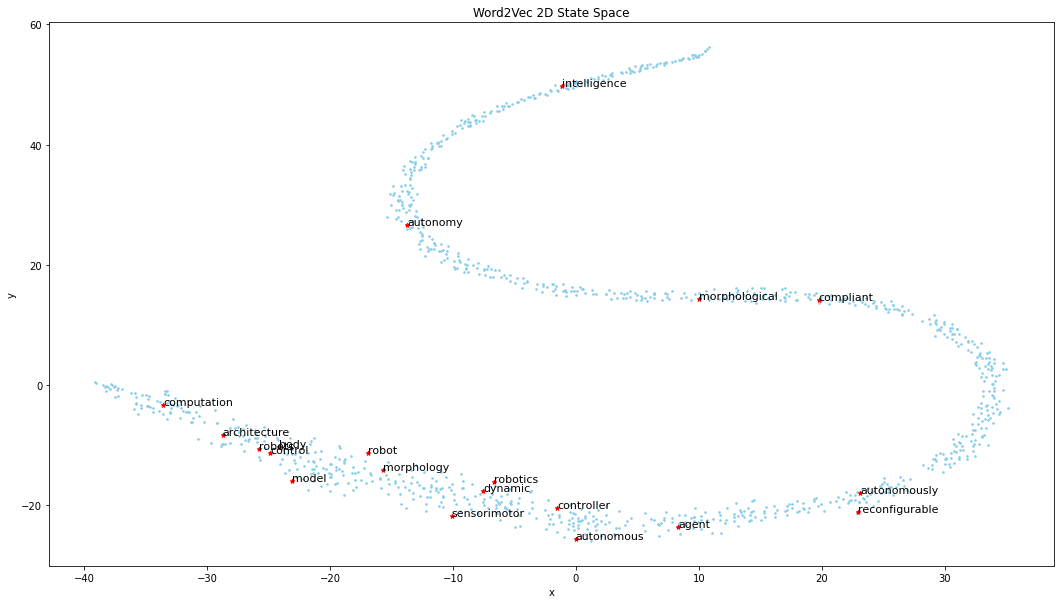

	Plotting keyword-specific regions in state space...
	INFO: Saved to reports/w2v__arg-dblim=0-pos=1-wlim=3000-qfea=300-wmin=3-wndw=7-samp=0.001-statespace=data_training.SVG_dynamic.SVG
	INFO: Saved to reports/w2v__arg-dblim=0-pos=1-wlim=3000-qfea=300-wmin=3-wndw=7-samp=0.001-statespace=data_training.SVG_controller.SVG
	INFO: Saved to reports/w2v__arg-dblim=0-pos=1-wlim=3000-qfea=300-wmin=3-wndw=7-samp=0.001-statespace=data_training.SVG_robot.SVG
	INFO: Saved to reports/w2v__arg-dblim=0-pos=1-wlim=3000-qfea=300-wmin=3-wndw=7-samp=0.001-statespace=data_training.SVG_architecture.SVG
	INFO: Saved to reports/w2v__arg-dblim=0-pos=1-wlim=3000-qfea=300-wmin=3-wndw=7-samp=0.001-statespace=data_training.SVG_control.SVG
	INFO: Saved to reports/w2v__arg-dblim=0-pos=1-wlim=3000-qfea=300-wmin=3-wndw=7-samp=0.001-statespace=data_training.SVG_robots.SVG
	INFO: Saved to reports/w2v__arg-dblim=0-pos=1-wlim=3000-qfea=300-wmin=3-wndw=7-samp=0.001-statespace=data_training.SVG_model.SVG
	INFO: Saved to repo

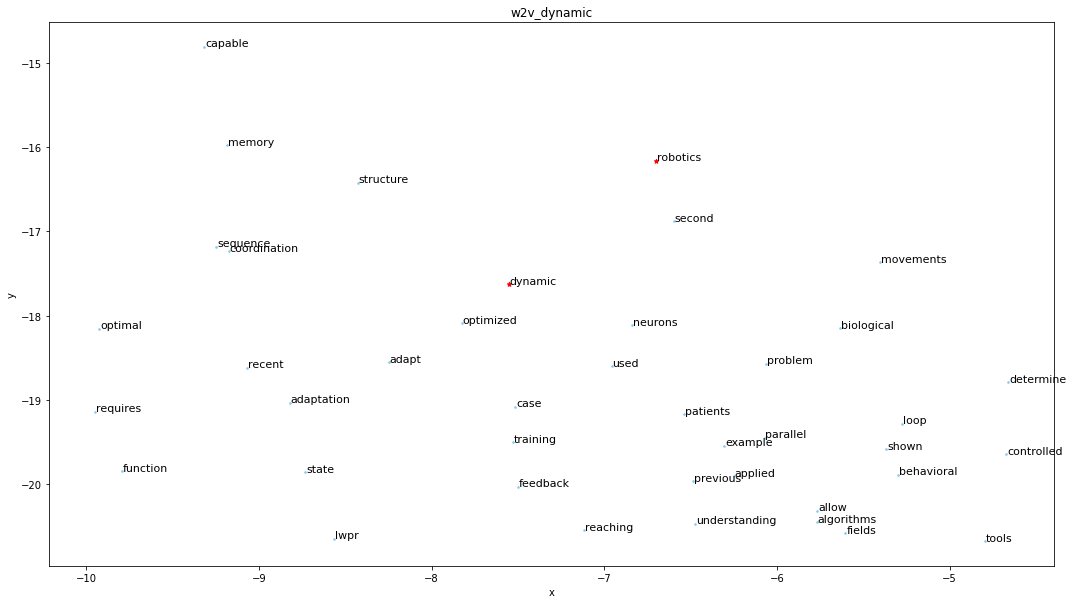

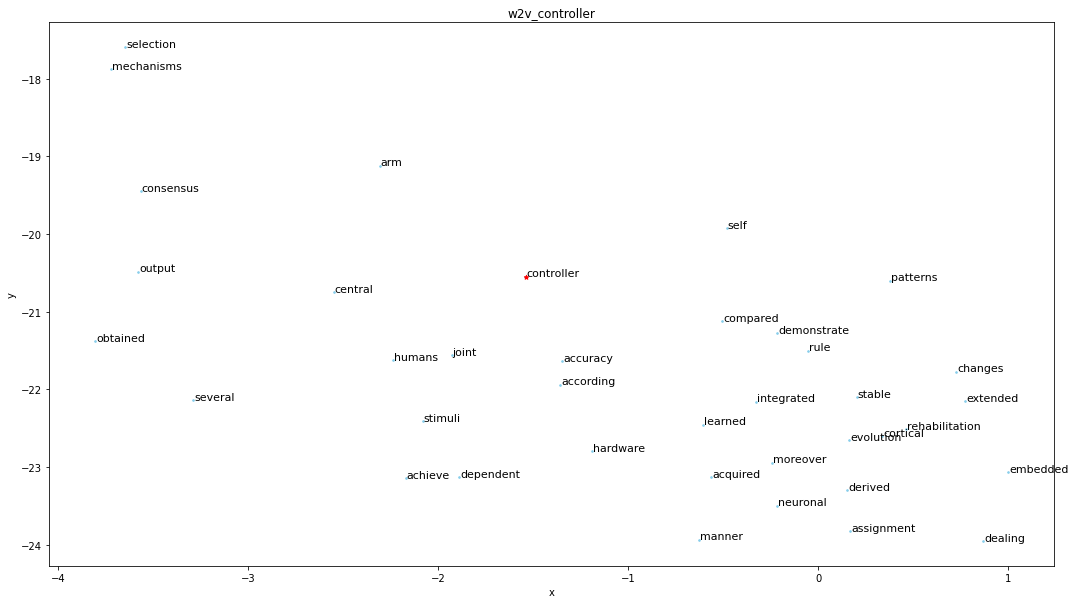

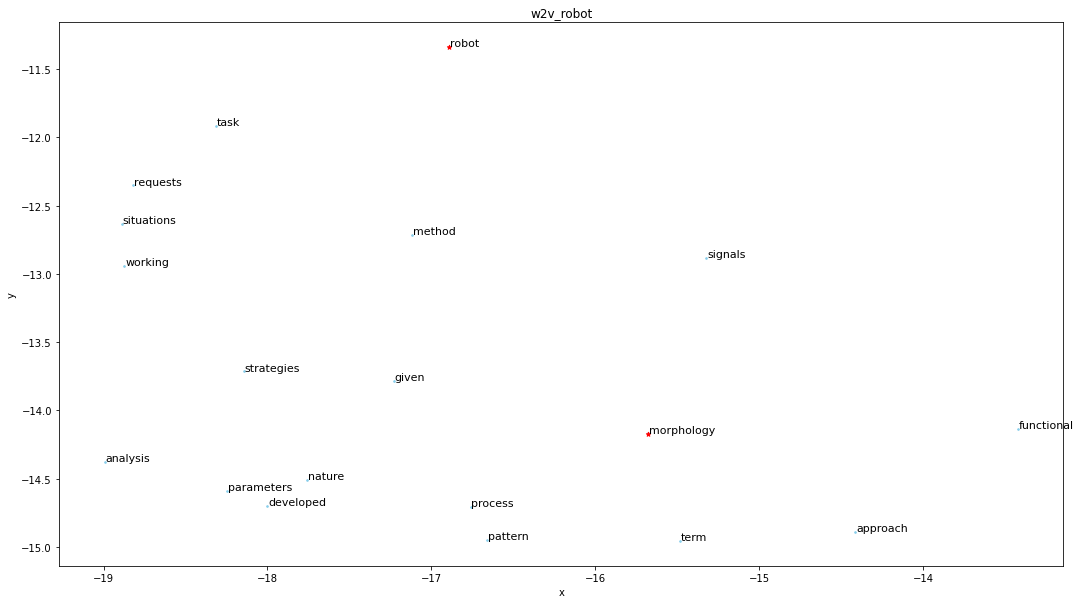

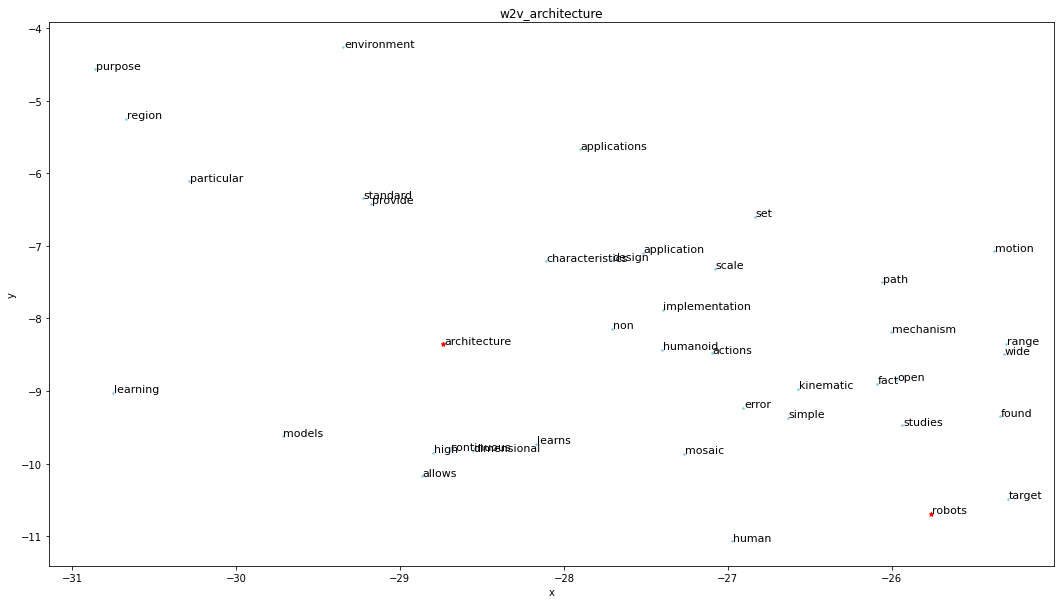

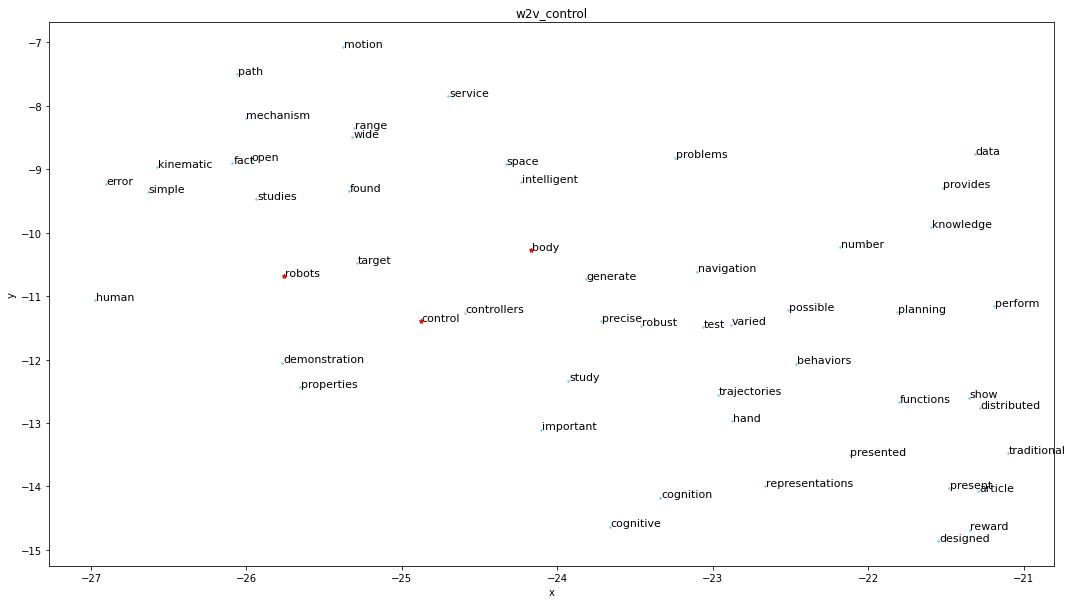

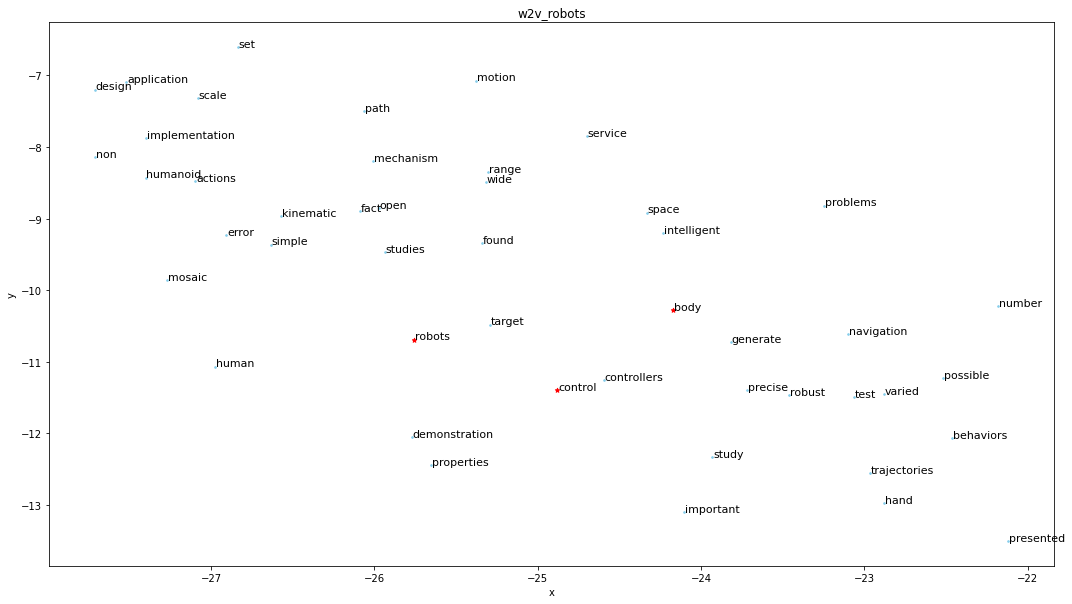

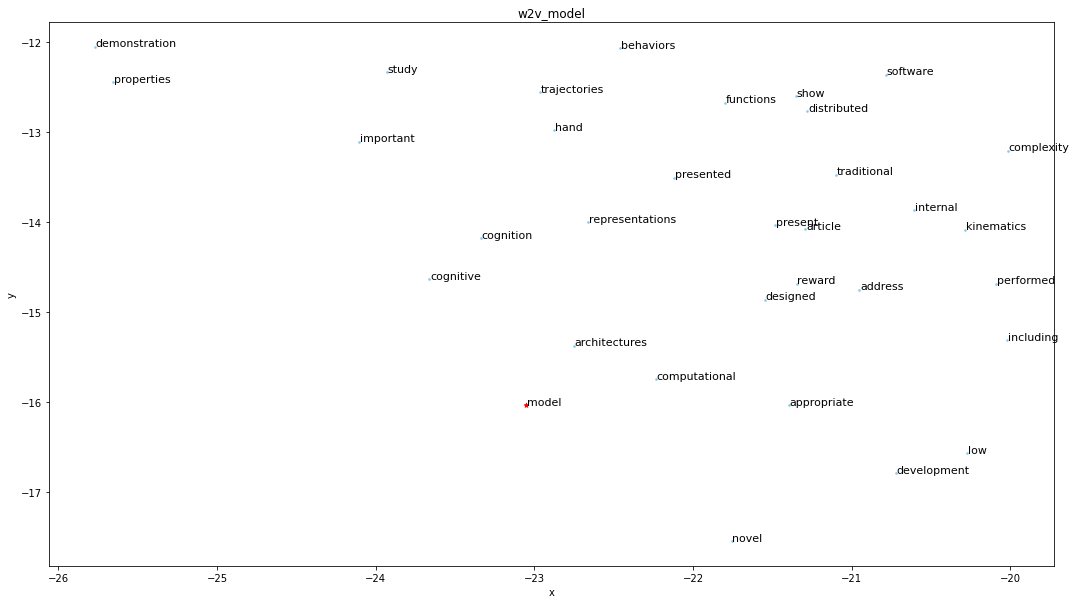

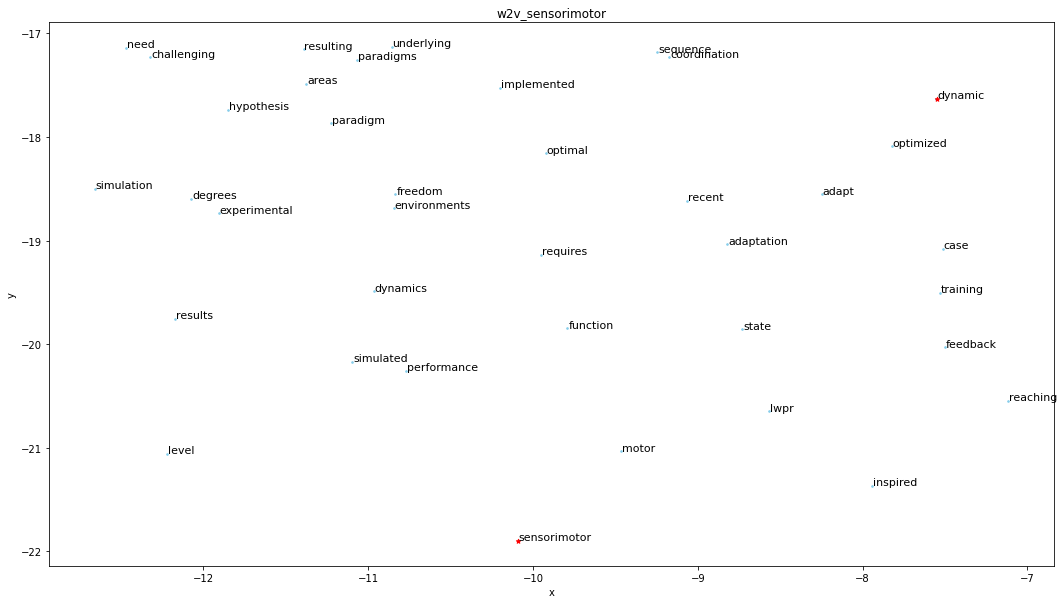

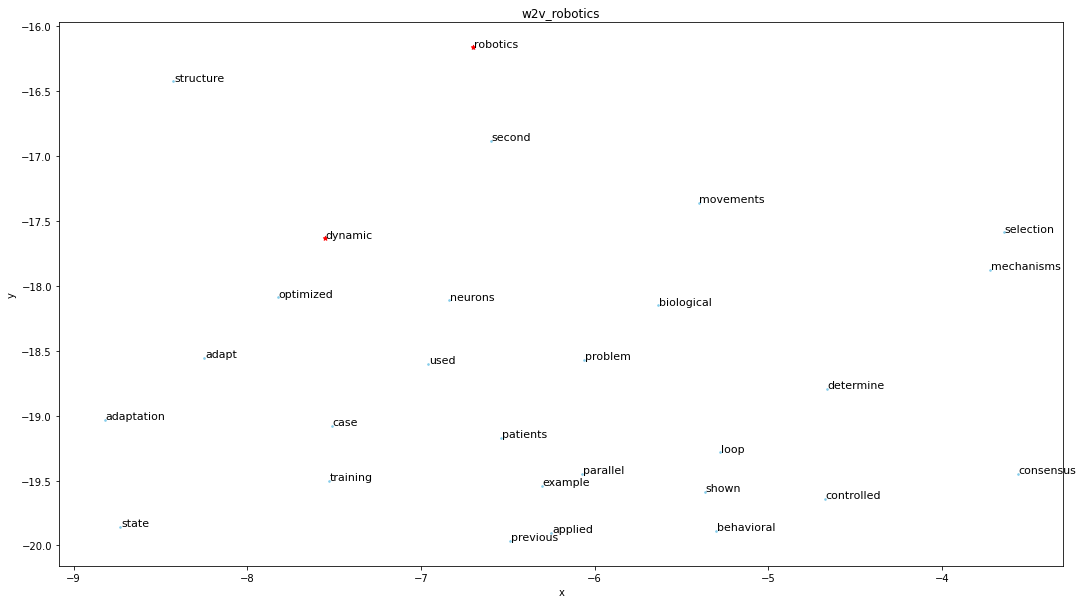

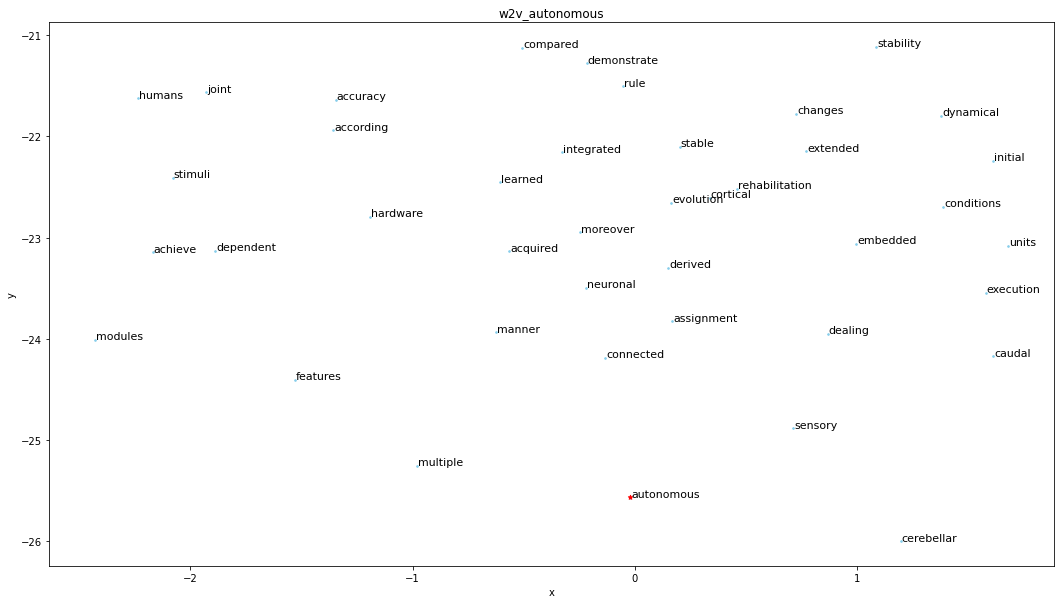

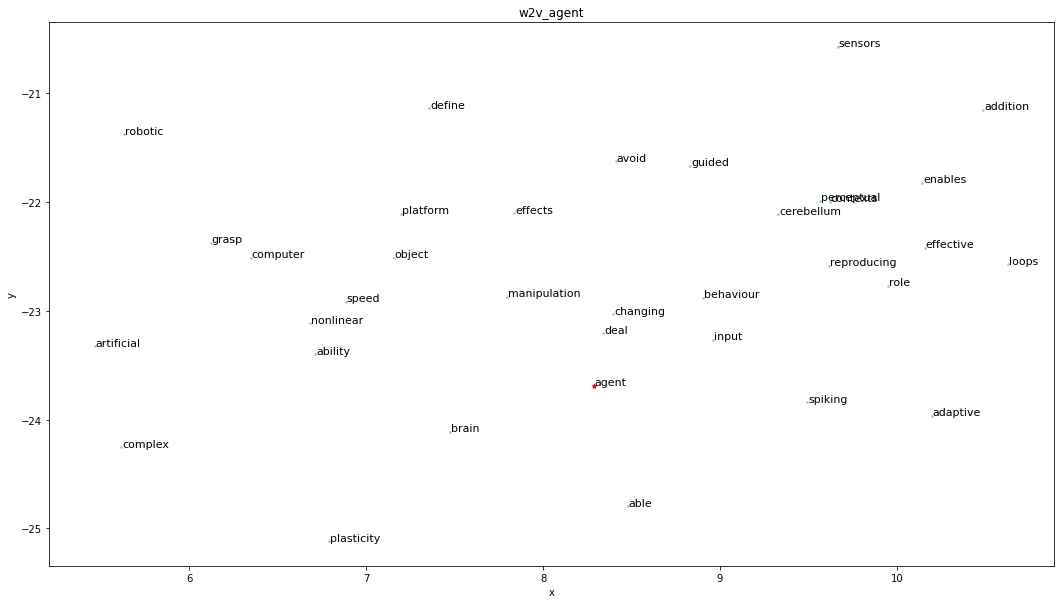

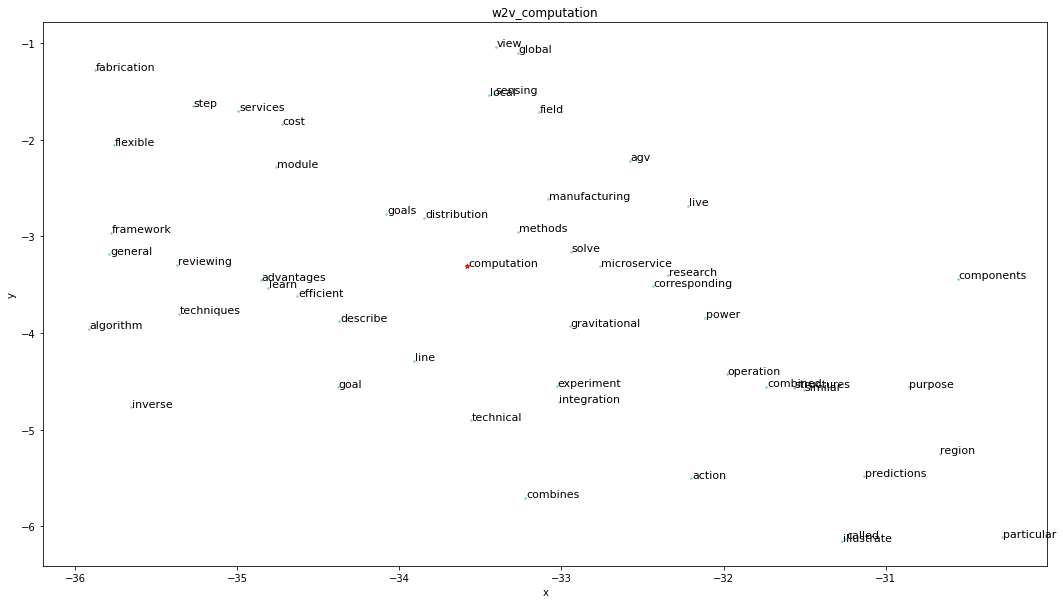

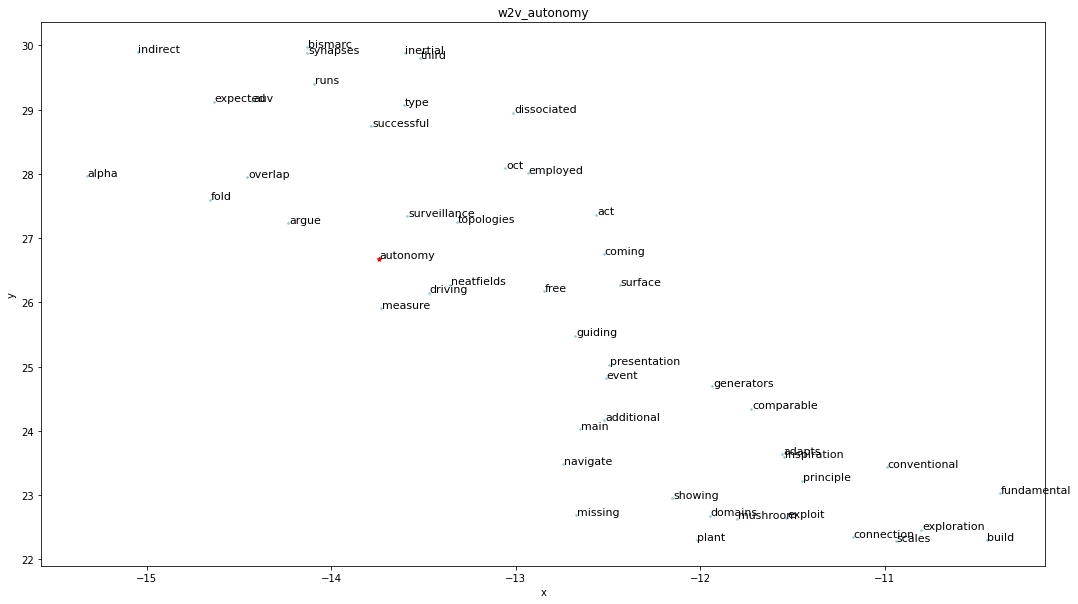

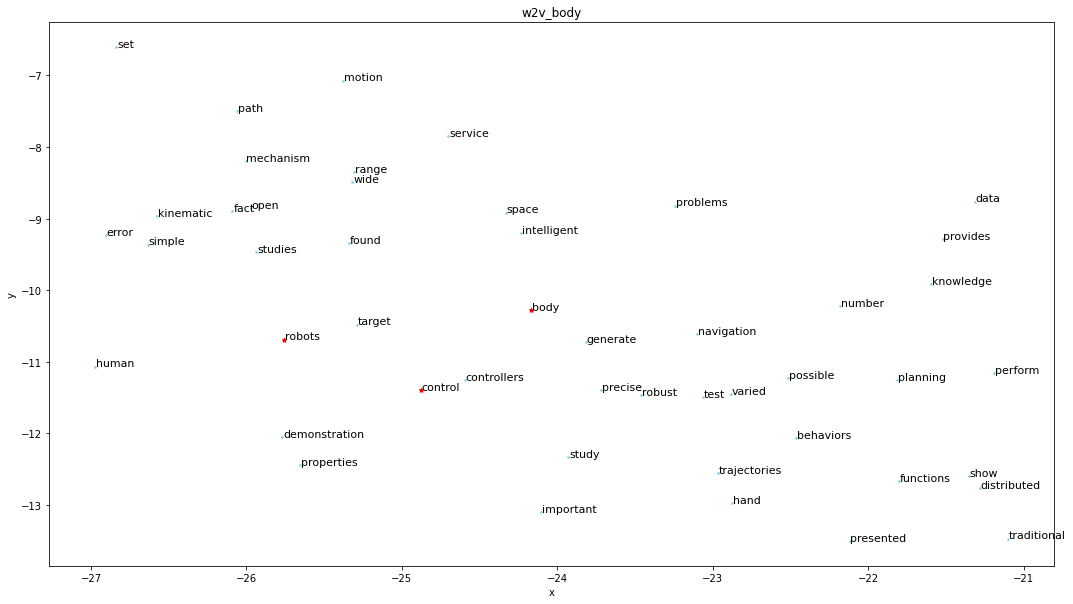

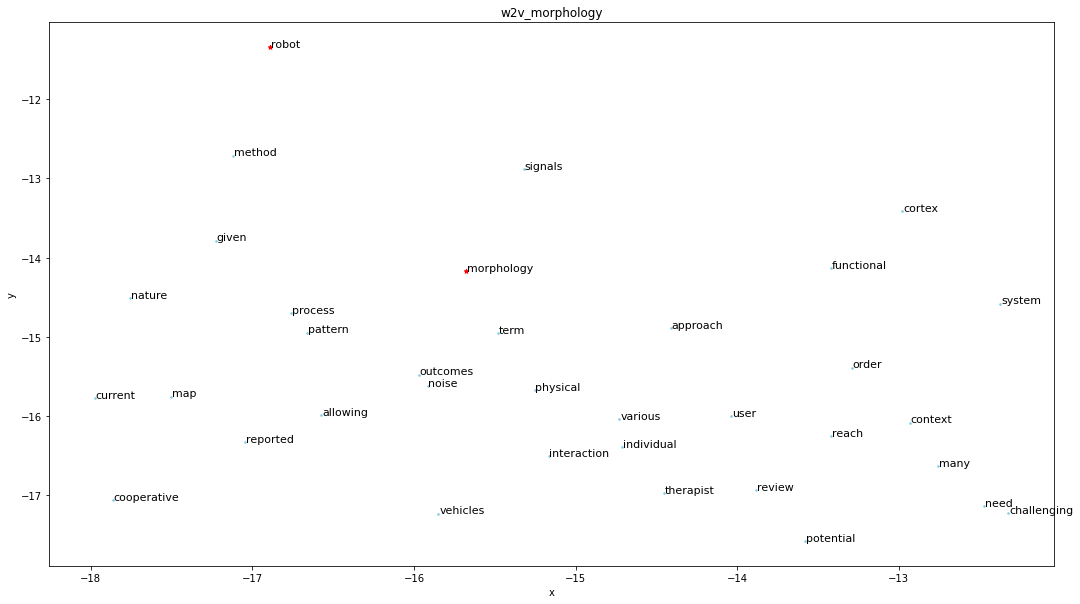

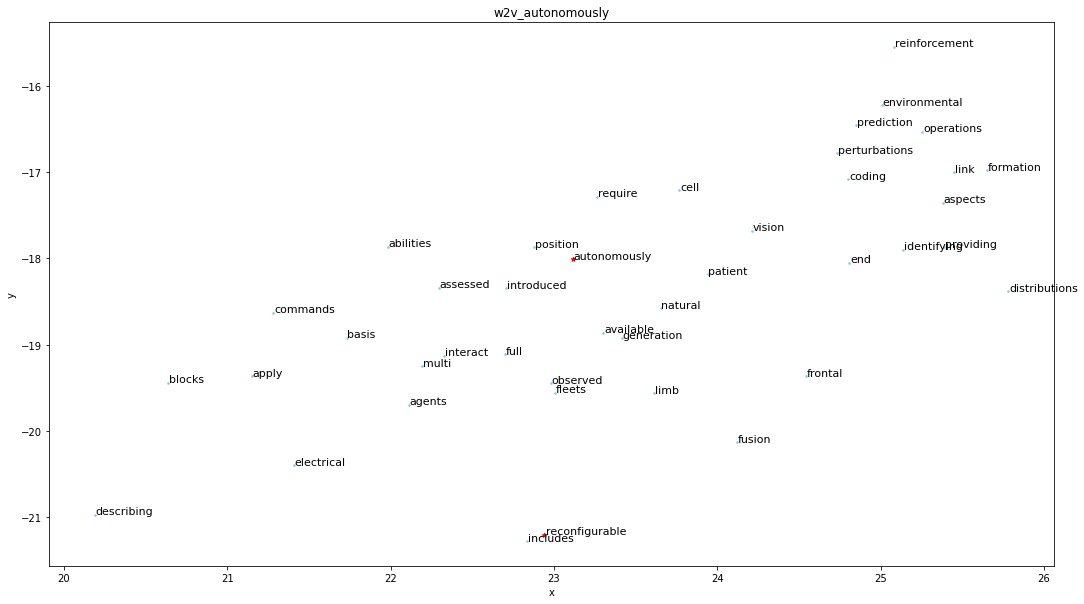

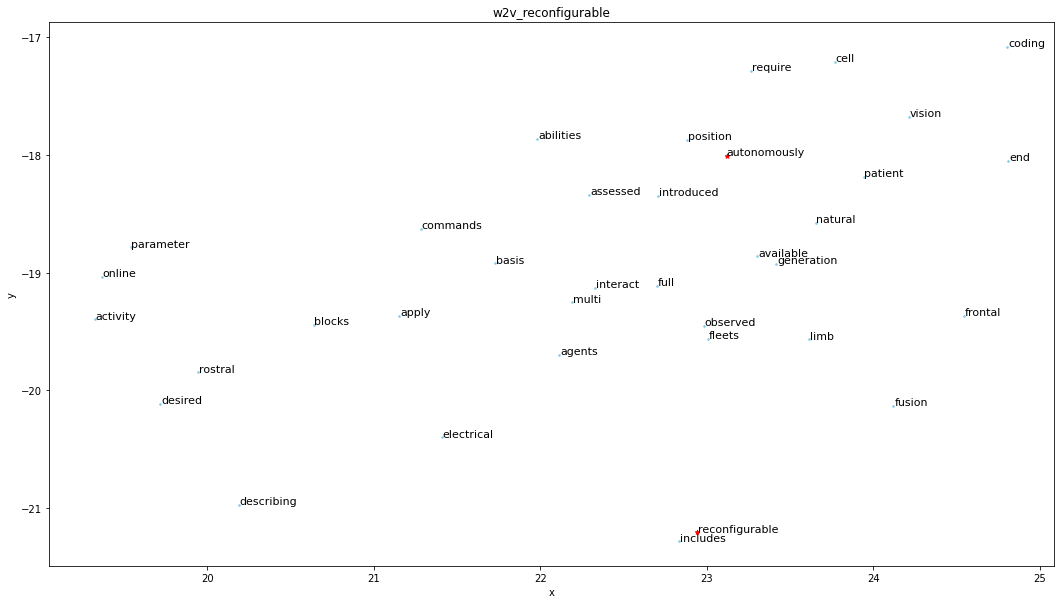

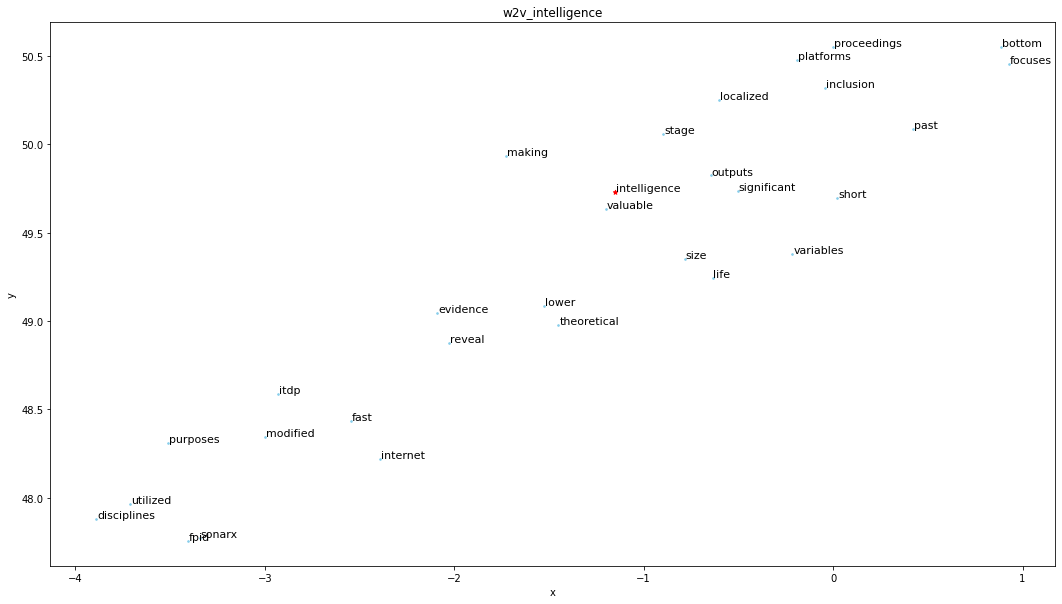

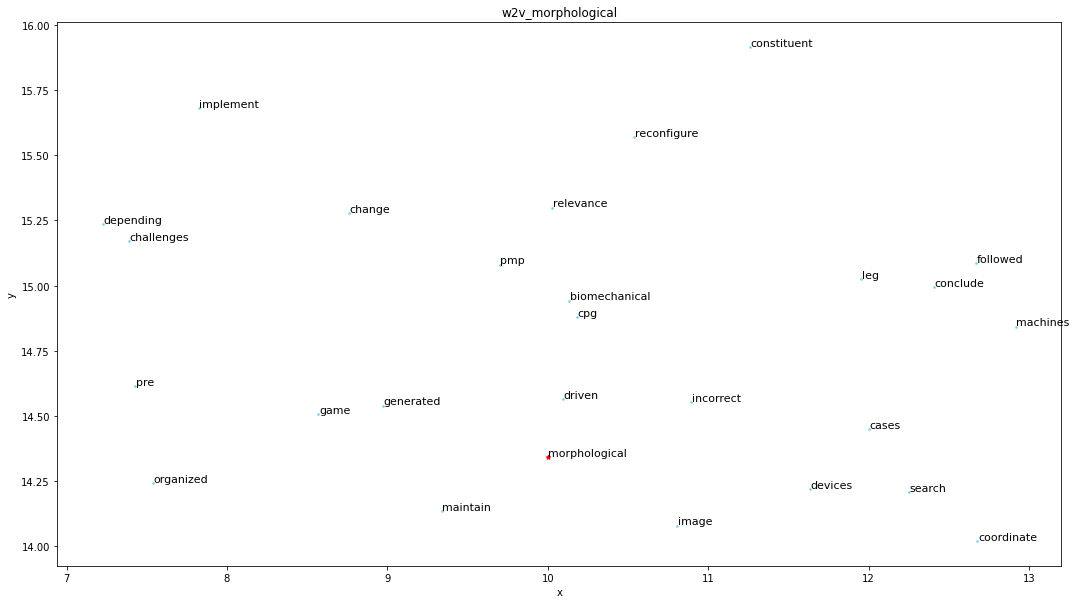

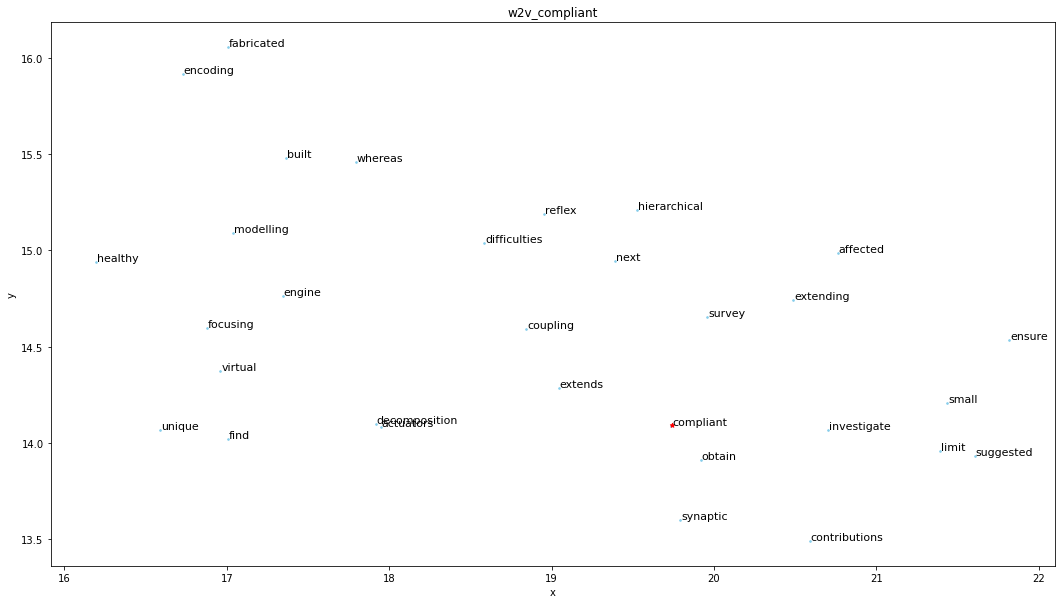

END visualize smart-filer_word2vec


In [43]:
#try:

#
recipe_load_featurize(0)

#
recipe_train_w2v(0)

#recipe_train_lsi(0)
#recipe_train_xdx(0)

#recipe_train_spam(0)
#recipe_exploit_spam(0)

#process_router(_INSTR_SPAM_APPLY, 1)
#process_router(_INSTR_LOAD_DB, 1)

#except:
#    print("FATAL")

In [ ]:
#recipe_train_spam(0)
#recipe_exploit_spam(0)

#recipe_train_xdx(0)

In [ ]:
#process_router(_INSTR_xDx_APPLY, 1)
#process_router(_INSTR_xDx_VISUALIZE, 0)

#process_router(_INSTR_FEATURIZE, 0)
#print(database)

In [200]:
USERARG_DATABASEFILE = "data_experiment_exemplar_train"   
recipe_load_featurize(0)
recipe_train_spam(0)
USERARG_DATABASEFILE = "data_experiment_exemplar_test"   
recipe_exploit_spam(0)
print("Done")

BEGIN load-database
	Loading database...
	Len(Database) =  609
	Completed in 0.96 seconds
	Ensuring non-empty documents in database...
	Set 0 empty documents to -NULL-
	Completed in 0.001 seconds
END load-database
BEGIN sanitize


[nltk_data] Downloading package averaged_perceptron_tagger to c:\users
[nltk_data]     \nk\appdata\local\programs\python\python38-32\lib\nltk
[nltk_data]     _data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to c:\users\nk\appdata\local
[nltk_data]     \programs\python\python38-32\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


	Extracting wordlists from docs and storing in database[FIELD_BzNDX_ABSTRACT_WORDS]...
	Completed in 1.808 seconds
	Applying parts-of-speech filter...
	Filtering abstract-word-list using words-list after PoS filtering...
		Confirmed reduction in document word-list
		 56656 words currently in corpus
	Completed in 38.47 seconds
	 56656 words in database
	Completed in 200.703 seconds
	NOTE: N-grams are underscore delimited words that tend to appear together
	NOTE: Repeating this process N-times yields an N-gram
	Compiling list of word-lists from database[FIELD_BzNDX_ABSTRACT_WORDS]...
	Building N-gram models...
	Example of a ngram: Phrases<49025 vocab, min_count=25, threshold=100, max_vocab_size=40000000>
	Replacing database[FIELD_BzNDX_ABSTRACT_WORDS] with ngrammed word-list...
	Completed in 1.794 seconds
	Compiling updated words list...
	Compiling list of word-lists from database[FIELD_BzNDX_ABSTRACT_WORDS]...
	Ngram report list...
	 6 distinct ngrams found a total of  338 times
	NGrams

[nltk_data] Downloading package averaged_perceptron_tagger to c:\users
[nltk_data]     \nk\appdata\local\programs\python\python38-32\lib\nltk
[nltk_data]     _data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to c:\users\nk\appdata\local
[nltk_data]     \programs\python\python38-32\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


	Completed in 7.746 seconds
	Applying parts-of-speech filter...
	Filtering abstract-word-list using words-list after PoS filtering...
		Confirmed reduction in document word-list
		 237680 words currently in corpus
	Completed in 517.105 seconds
	 237680 words in database
	Completed in 1195.073 seconds
	NOTE: N-grams are underscore delimited words that tend to appear together
	NOTE: Repeating this process N-times yields an N-gram
	Compiling list of word-lists from database[FIELD_BzNDX_ABSTRACT_WORDS]...
	Building N-gram models...
	Example of a ngram: Phrases<147095 vocab, min_count=25, threshold=100, max_vocab_size=40000000>
	Replacing database[FIELD_BzNDX_ABSTRACT_WORDS] with ngrammed word-list...
	Completed in 7.019 seconds
	Compiling updated words list...
	Compiling list of word-lists from database[FIELD_BzNDX_ABSTRACT_WORDS]...
	Ngram report list...
	 46 distinct ngrams found a total of  3437 times
	NGrams:  ['unmanned_aerial', 'elsevier_ltd', 'receding_horizon', 'elsevier_ltd', 'mon

In [ ]:
#NB
#TRAIN  _matches = [358,437,70,73,82,196,217,293,342,396,469,511,83,102,171,225,353,386,533]
#SCOPUS _matches = [1808,1894,1962,2565,2803,2847,3165,3737,4070,4453,4892,5218,5293,5296,5671,5855,5886,5997,6451,6999,7378,7617,7795,7930,8280,8507,8640,8660,8755,8824,9535,9547,9955,10019,10217,11001,11259,11626,11646,12321]
_matches = [59,70,73,82,83,102,105,150,171,196,217,225,293,330,342,353,358,386,390,391,396,426,437,469,471,491,511,533,621]


#ADA
#_matches = [9547,2686,4759,9000,9610,5780,6077,8057,1121,4533,7924,9099,9955,1431,2106,2620,3010,3013,6381,7055,7492,8253,8284,8971,9647,11061,11400,12070]

for i in range(len(_matches)):
    try:
        print(_matches[i], "\t", database[_matches[i]-1][FIELD_BzNDX_DOCID], "\t", database[_matches[i]-1][FIELD_BzNDX_INT_CLASS], "\t", database[_matches[i]-1][FIELD_BzNDX_BIN_CLASS], "\t", database[_matches[i]-1][FIELD_BzNDX_ABSTRACT], "\n")
    except:
        print(_matches[i], "\t", "MISSING", "\n")

In [ ]:
print("END application")

In [195]:
# dir() will give you the list of in scope variables:
# globals() will give you a dictionary of global variables
# locals() will give you a dictionary of local variables

# MAGICKS (%prefixed commands)
# %who
%whos


Variable                            Type                    Data/Info
---------------------------------------------------------------------
AdaBoostClassifier                  ABCMeta                 <class 'sklearn.ensemble.<...>ting.AdaBoostClassifier'>
COMMON_WORDS                        NoneType                None
Counter                             type                    <class 'collections.Counter'>
EMPTY_DOCUMENT_VALUE                str                     -NULL-
FIELD_BzNDX_ABSTRACT                int                     3
FIELD_BzNDX_ABSTRACT_WORDS          int                     4
FIELD_BzNDX_BIN_CLASS               int                     2
FIELD_BzNDX_DOCID                   int                     0
FIELD_BzNDX_INT_CLASS               int                     1
HdpModel                            type                    <class 'gensim.models.hdpmodel.HdpModel'>
KEYWORDS                            list                    n=42
LdaModel                            type     

In [ ]:
print(list([len(database), len(database[0])]))
print(FIELD_BzNDX_ABSTRACT_WORDS)
#database[0][FIELD_BzNDX_ABSTRACT_WORDS]
for i in range(0,len(database),1):
    if len(database[i]) != 5:
        print(["Incorrect size at rec " , i])
